In [1]:
import pandas as pd
import numpy as np

from pyfaidx import Fasta
from scipy.stats import spearmanr,pearsonr

%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset,DataLoader

def train(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, 
          learning_rate: float, num_epochs: int, device: torch.device):
    """
    训练模型的主循环。

    参数:
    model (nn.Module): 要训练的模型。
    train_loader (DataLoader): 训练数据的 DataLoader。
    val_loader (DataLoader): 验证数据的 DataLoader。
    learning_rate (float): 初始学习率。
    num_epochs (int): 训练的周期数。
    device (torch.device): 训练设备 ('cuda' 或 'cpu')。
    """
    # 1. 初始化优化器和损失函数
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # 使用CrossEntropyLoss处理one-hot标签
    loss_fn = nn.BCELoss()

    # 2. 将模型移动到目标设备
    model.to(device)

    print(f"Starting training for {num_epochs} epochs on device: {device}")

    for epoch in range(num_epochs):
        # --- 训练阶段 ---
        model.train() # 设置为训练模式
        train_loss = 0.0
        
        # 使用 tqdm 封装 DataLoader 以显示进度
        train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)")
        
        for batch_idx, (seq, target, ct) in enumerate(train_loop):
            # 1. 数据移动到设备
            # DNA独热编码 (B, L, 4) -> (B, 4, L)
            seq= seq.float().permute(0, 2, 1).to(device) 
            # target已经是one-hot形式 (B, 2)，不需要转换
            target = target.to(device)  # 保持 (B, 2) 形状
            
            # 2. 前向传播
            output = model(seq,ct)
            # 3. 计算损失 - 使用CrossEntropyLoss处理one-hot标签
            loss = loss_fn(output, target)

            # 4. 反向传播和优化
            optimizer.zero_grad() # 梯度清零
            loss.backward() # 反向传播
            optimizer.step() # 更新参数

            train_loss += loss.item() * len(seq)
            train_loop.set_postfix(loss=loss.item())

        avg_train_loss = train_loss / len(train_loader.dataset)

        # --- 验证阶段 ---
        model.eval() # 设置为评估模式
        val_loss = 0.0
        correct_predictions = 0
        
        with torch.no_grad(): # 禁用梯度计算
            for seq, target, ct in val_loader:
                seq = seq.float().permute(0, 2, 1).to(device)
                target = target.to(device)  # 保持 (B, 2) 形状

                output = model(seq, ct)
                loss = loss_fn(output, target)
                val_loss += loss.item() * len(seq)

                # 计算准确率 - 使用argmax获取预测类别
                # output形状 (B, 2)，取最大值的索引作为预测类别
                predicted_classes = torch.where(output>0.5, 1, 0) 
                # target形状 (B, 2)，取最大值的索引作为真实类别
                true_classes = target
                correct_predictions += (predicted_classes == true_classes).sum().item()

        avg_val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = correct_predictions / len(val_loader.dataset)

        print(f"\nEpoch {epoch+1} Summary:")
        print(f"  Train Loss: {avg_train_loss:.4f}")
        print(f"  Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.4f}")

    print("Training finished.")


def predict(model: nn.Module, data_loader: DataLoader, device: torch.device) -> torch.Tensor:
    """
    对给定数据集进行预测。

    参数:
    model (nn.Module): 训练好的 Sei 模型。
    data_loader (DataLoader): 待预测数据的 DataLoader。
    device (torch.device): 预测设备 ('cuda' 或 'cpu')。

    返回:
    torch.Tensor: 模型的输出 (Sigmoid激活后的概率值)。
    """
    model.to(device)
    model.eval() # 设置为评估模式
    all_predictions = []

    print("Starting prediction...")
    
    with torch.no_grad(): # 禁用梯度计算
        for SEQ, _, CT in tqdm(data_loader, desc="Predicting"):
            # 前向传播
            SEQ = SEQ.float().permute(0, 2, 1).to(device)
            output = model(SEQ, CT)
            all_predictions.append(output.cpu())

    # 拼接所有批次的预测结果
    return torch.cat(all_predictions, dim=0)

In [3]:
class SeqDataset(Dataset):
    def __init__(self, sequences, labels, celltypes, vocab=None):
        self.sequences = sequences
        self.labels = labels
        self.celltypes = celltypes
        
        # 如果你没有提前定义字典，这里自动创建一个简单的碱基映射
        if vocab is None:
            vocab = {'A': 0, 'C': 1, 'G': 2, 'T': 3, 'N': 4}
        self.vocab = vocab

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq   = self.sequences[idx]
        label = self.labels[idx]
        ct    = self.celltypes[idx]
        return seq, label, ct

In [4]:
class CrossCellLineModel(nn.Module):
    
    def __init__(self,base_model,cell_type_num=32,device='cuda:1'):
        super().__init__()
        self.base_model = nn.ModuleList([base_model(sequence_length=512, n_genomic_features=1) for _ in range(cell_type_num)])
        self.device = device
        
    def forward(self,seq,ct):
        batch_size = seq.shape[0]
        outputs = torch.zeros(batch_size, device=self.device)

        # 为每个模型收集属于它的样本
        for model_idx in range(len(self.base_model)):
            # 找出使用当前模型的样本索引
            mask = (ct == model_idx)
            if mask.sum() > 0:  # 有样本使用这个模型
                # 批量处理所有使用同一模型的样本
                batch_seq = seq[mask]
                batch_output = self.base_model[model_idx](batch_seq)
                outputs[mask] = batch_output.flatten()

        return outputs

In [ ]:
import pickle
from tqdm import tqdm

with open('/cluster2/huanglab/liquan/data/eSCREEN/Demo/data/demo_dataset.pkl','rb') as file:
    data = pickle.load(file)
    
trainset = data['Trainset']
testset  = data['Testset']
validset = data['Validset']

base_to_array={'A':[1,0,0,0],'C':[0,1,0,0],'G':[0,0,1,0],'T':[0,0,0,1],'N':[0,0,0,0]}
cell_type_dict = {'K562':0,'HepG2':1,'hPSC':2,'A549':3}

def one_hot(seq):return np.stack( np.array( [base_to_array[a] for a in seq] ) )

trainset['one hot'] = None
for i,row in tqdm(trainset.iterrows(),total=len(trainset)):
    trainset.at[i,'one hot'] = one_hot(row['sequence'])
train_ohe = np.stack(trainset['one hot'])
testset['one hot'] = None
for i,row in tqdm(testset.iterrows(),total=len(testset)):
    testset.at[i,'one hot'] = one_hot(row['sequence'])
test_ohe = np.stack(testset['one hot'])
validset['one hot'] = None
for i,row in tqdm(validset.iterrows(),total=len(validset)):
    validset.at[i,'one hot'] = one_hot(row['sequence'])
valid_ohe = np.stack(validset['one hot'])

_X_train_ = torch.tensor(train_ohe)
X_train = torch.zeros(_X_train_.size(0),512,4)
X_train[:,6:506,:] = _X_train_
Y_train = torch.tensor(trainset['label'].values,dtype=torch.float)
Z_train = torch.tensor(np.stack([cell_type_dict[ct] for ct in trainset['cell_line'].values])).int()

_X_test_ = torch.tensor(test_ohe)
X_test = torch.zeros(_X_test_.size(0),512,4)
X_test[:,6:506,:] = _X_test_
Y_test = torch.tensor(testset['label'].values,dtype=torch.float)
Z_test = torch.tensor(np.stack([cell_type_dict[ct] for ct in testset['cell_line'].values])).int()

_X_valid_ = torch.tensor(valid_ohe)
X_valid = torch.zeros(_X_valid_.size(0),512,4)
X_valid[:,6:506,:] = _X_valid_
Y_valid = torch.tensor(validset['label'].values,dtype=torch.float)
Z_valid = torch.tensor(np.stack([cell_type_dict[ct] for ct in validset['cell_line'].values])).int()

train_data   = SeqDataset(X_train, Y_train, Z_train)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

test_data   = SeqDataset(X_test, Y_test, Z_test)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

valid_data   = SeqDataset(X_valid, Y_valid, Z_valid)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
from Sei import Sei,SeiMini
CCModel = CrossCellLineModel(SeiMini, cell_type_num=4, device='cuda:0')
LR = 1e-4
EPOCHS = 20
train(CCModel, train_loader, test_loader, LR, EPOCHS, device='cuda:0')
torch.save(CCModel,'Sei.pth')

Starting training for 20 epochs on device: cuda:0


Epoch 1/20 (Train): 100%|██████████| 1385/1385 [01:54<00:00, 12.12it/s, loss=0.651]



Epoch 1 Summary:
  Train Loss: 0.7525
  Validation Loss: 0.7417, Accuracy: 0.4995


Epoch 2/20 (Train): 100%|██████████| 1385/1385 [01:52<00:00, 12.26it/s, loss=0.67] 



Epoch 2 Summary:
  Train Loss: 0.7376
  Validation Loss: 0.7290, Accuracy: 0.4995


Epoch 3/20 (Train): 100%|██████████| 1385/1385 [01:53<00:00, 12.21it/s, loss=0.778]



Epoch 3 Summary:
  Train Loss: 0.7261
  Validation Loss: 0.7192, Accuracy: 0.4995


Epoch 4/20 (Train): 100%|██████████| 1385/1385 [01:53<00:00, 12.23it/s, loss=0.724]



Epoch 4 Summary:
  Train Loss: 0.7172
  Validation Loss: 0.7118, Accuracy: 0.4995


Epoch 5/20 (Train): 100%|██████████| 1385/1385 [01:53<00:00, 12.23it/s, loss=0.718]



Epoch 5 Summary:
  Train Loss: 0.7106
  Validation Loss: 0.7063, Accuracy: 0.4995


Epoch 6/20 (Train): 100%|██████████| 1385/1385 [01:53<00:00, 12.24it/s, loss=0.729]



Epoch 6 Summary:
  Train Loss: 0.7058
  Validation Loss: 0.7025, Accuracy: 0.4995


Epoch 7/20 (Train): 100%|██████████| 1385/1385 [01:53<00:00, 12.23it/s, loss=0.736]



Epoch 7 Summary:
  Train Loss: 0.7023
  Validation Loss: 0.6998, Accuracy: 0.4995


Epoch 8/20 (Train): 100%|██████████| 1385/1385 [01:53<00:00, 12.24it/s, loss=0.692]



Epoch 8 Summary:
  Train Loss: 0.6998
  Validation Loss: 0.6979, Accuracy: 0.4995


Epoch 9/20 (Train): 100%|██████████| 1385/1385 [01:53<00:00, 12.19it/s, loss=0.678]



Epoch 9 Summary:
  Train Loss: 0.6981
  Validation Loss: 0.6965, Accuracy: 0.4995


Epoch 10/20 (Train): 100%|██████████| 1385/1385 [01:53<00:00, 12.22it/s, loss=0.695]



Epoch 10 Summary:
  Train Loss: 0.6968
  Validation Loss: 0.6956, Accuracy: 0.4995


Epoch 11/20 (Train): 100%|██████████| 1385/1385 [01:54<00:00, 12.14it/s, loss=0.666]



Epoch 11 Summary:
  Train Loss: 0.6959
  Validation Loss: 0.6949, Accuracy: 0.4995


Epoch 12/20 (Train): 100%|██████████| 1385/1385 [01:54<00:00, 12.10it/s, loss=0.698]



Epoch 12 Summary:
  Train Loss: 0.6952
  Validation Loss: 0.6944, Accuracy: 0.4995


Epoch 13/20 (Train): 100%|██████████| 1385/1385 [01:54<00:00, 12.14it/s, loss=0.689]



Epoch 13 Summary:
  Train Loss: 0.6947
  Validation Loss: 0.6940, Accuracy: 0.4995


Epoch 14/20 (Train): 100%|██████████| 1385/1385 [01:54<00:00, 12.07it/s, loss=0.7]  



Epoch 14 Summary:
  Train Loss: 0.6943
  Validation Loss: 0.6938, Accuracy: 0.4995


Epoch 15/20 (Train): 100%|██████████| 1385/1385 [01:54<00:00, 12.12it/s, loss=0.701]



Epoch 15 Summary:
  Train Loss: 0.6940
  Validation Loss: 0.6936, Accuracy: 0.4995


Epoch 16/20 (Train): 100%|██████████| 1385/1385 [01:53<00:00, 12.16it/s, loss=0.707]



Epoch 16 Summary:
  Train Loss: 0.6938
  Validation Loss: 0.6934, Accuracy: 0.4995


Epoch 17/20 (Train): 100%|██████████| 1385/1385 [01:54<00:00, 12.11it/s, loss=0.713]



Epoch 17 Summary:
  Train Loss: 0.6936
  Validation Loss: 0.6933, Accuracy: 0.5011


Epoch 18/20 (Train):  82%|████████▏ | 1136/1385 [01:34<00:20, 12.02it/s, loss=0.694]

In [10]:
CCModel = torch.load('Sei.pth',weights_only=False)
valid_predictions = predict(CCModel, valid_loader, 'cuda:0')
predicted_classes = torch.where(valid_predictions>0.5, 1, 0)

Starting prediction...


Predicting: 100%|██████████| 174/174 [00:03<00:00, 52.53it/s]


AUC: 0.5032
MCC: -0.0174
F1 Score: 0.6285
Accuracy: 0.4920
Recall: 0.8645
Precision: 0.4937


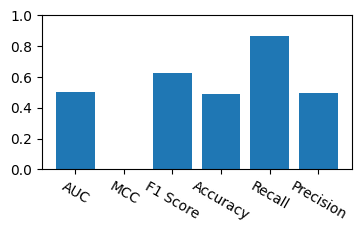

In [11]:
from sklearn.metrics import matthews_corrcoef, f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

predictions = valid_predictions;labels = Y_valid
predicted_labels = [1 if p >= 0.5 else 0 for p in predictions]

# 计算指标
auc_val = auc(roc_curve(labels, predictions)[0],roc_curve(labels, predictions)[1])
mcc = matthews_corrcoef(labels, predicted_labels)
f1 = f1_score(labels, predicted_labels)
accuracy = accuracy_score(labels, predicted_labels)
recall = recall_score(labels, predicted_labels)
precision = precision_score(labels, predicted_labels)

# 输出结果
print(f"AUC: {auc_val:.4f}")
print(f"MCC: {mcc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

plt.figure(figsize=(4,2))
plt.bar([1,2,3,4,5,6],[auc_val,mcc,f1,accuracy,recall,precision])
plt.ylim([0,1])
plt.xticks([1,2,3,4,5,6],["AUC","MCC","F1 Score","Accuracy","Recall","Precision"],rotation=-30)
plt.show()